In [1]:
%matplotlib inline
import numpy as np
from numpy import loadtxt
from lmfit import Model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from uncertainties import ufloat




In [2]:
data_208=loadtxt('Data/Corina_Ian_Thres208mVIntervals2015_11_05-13-33.txt'\
                 ,unpack=True)[1]
data_400=loadtxt('Data/Corina_Ian_Thres400mVIntervals2015_11_10-13-24.txt'\
                 ,unpack=True)[1]
data_Luke=loadtxt('Data/Luke_Ian/Luke_Perry2015_12_01-13-39.txt'\
                 ,unpack=True)[1]
combine_data = np.concatenate((data_400,data_208))

In [3]:
def expDecay(t,tau,amp,background):
    return amp*np.exp(-t/tau)+background
def filterList(counts,bin_centres):
    returnCent = []
    returnBinC = []
    for i in range(0,len(counts)):
        if counts[i]==0:
            continue
        returnCent.append(counts[i])
        returnBinC.append(bin_centres[i])
    return np.array(returnCent),np.array(returnBinC)

def doFit(raw_data,bins=50):
    counts,bin_edges=np.histogram(raw_data,bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    counts,bin_centres = filterList(counts,bin_centres)
    while counts[0]-counts[1]<0:
        bin_centres=bin_centres[1:]
        counts=counts[1:]
    err = np.sqrt(counts)
    if abs(counts[0]-counts[1])<abs(2*(err[0]+err[1])):
        bin_centres=bin_centres[1:]
        counts=counts[1:]
        err = err[1:]

    if bins<30:
        counts = counts[1:]
        bin_centres = bin_centres[1:]
    err = np.sqrt(counts)
    mod = Model(expDecay)
    pars = mod.make_params(tau=2000, amp=counts[0], background=counts[len(counts)-1])
    out = mod.fit(counts, pars, t=bin_centres,weights=1./err)
    return (bin_centres,counts),out
def fit_plot(raw_data,bins=50,plt_init=False):
    data,out=doFit(raw_data,bins)

    fig1 = plt.figure(1,figsize=(15,10))
    frame1=fig1.add_axes((.1,.1,.8,.75))
    plt.errorbar(data[0], data[1], fmt='o',yerr=np.sqrt(data[1]))
    plt.plot(data[0], out.best_fit, '-')
    #print(out.best_fit[0])
    print(data[0][0])
    if plt_init:
        plt.plot(data[0],out.init_fit,'--')
    plt.xlabel('Lifetime')
    plt.ylabel('Counts')

    frame2=fig1.add_axes((.1,.9,.8,.2))
    residuals = []
    for i in range(len(data[0])):
        residuals.append(expDecay(data[0][i],out.best_values['tau'],out.best_values['amp'], 
                                  out.best_values['background'])-data[1][i]) 
    #print(residuals)
    #print(out.best_fit[0])
    #print(data[1][0])
    #print(expDecay(data[0][0],out.best_values['tau'],out.best_values['amp'], 
                                  #out.best_values['background']))
    #print(out.best_values['tau'])
    #print(out.best_values['amp'])
    #print(out.best_values['background'])
    print(redchiSq(data[1],out.best_fit,3))
    print(out.redchi)
    #plt.errorbar(data[0],residuals,fmt='o',yerr=np.sqrt(data[1]))
    plt.plot(data[0],out.residual,'o')
    plt.axhline(color='black')
    frame2.set_xticklabels([])
    
    out.plot()
    plt.show()
def chiSq_Plot(raw_data,minB,maxB,title=r'$\tilde{\chi}}^2$'+' vs binning',pdfPages=None):
    redChi=[]
    plt.figure(figsize=(10,10))
    for i in range(minB,maxB):
        redChi.append(doFit(raw_data,i)[1].redchi)
    plt.rc('text', usetex=True)
    plt.ylabel(r'$\tilde{\chi}^2$')
    plt.xlabel('Number of Bins')
    plt.plot(range(minB,maxB),redChi,'ko')
    plt.title(title)
    plt.show()
    if pdfPages is not None:
        plt.savefig(pdfPages, format='pdf')
    
def bestValue_Plot(raw_data,minB,maxB,title='Tau vs Bins',pdfPages=None):
    tau=[]
    err=[]
    for i in range(minB,maxB):
        out = doFit(raw_data,i)[1]
        tau.append(out.best_values['tau'])
        err.append(out.params['tau'].stderr)
    plt.figure(figsize=(10,10))
    plt.ylabel('Tau')
    plt.xlabel('Number of Bins')
    plt.errorbar(range(minB,maxB),tau,fmt='ko',yerr=err)
    plt.title(title)
    plt.grid(True)
    plt.show()
    if pdfPages is not None:
        plt.savefig(pdfPages, format='pdf')
def detectorLifeTime(tau_obs):
    tau_plus = ufloat(2.1969811, 0.0000022)*10**3
    #tau_plus = 2196.9811
    rho      = 1.1
    #return tau_plus*tau_obs
    numerator = tau_plus*tau_obs
    denominator = rho*tau_plus + tau_plus -rho*tau_obs
    #return tau_plus*tau_obs/((1+rho)*tau_plus-rho*tau_obs)
    return numerator/denominator
def detectorLifeTime_Plot(raw_data,minB,maxB,title='Detector Lifetime',pdfPages=None):
    detLife = []
    err = []
    bins = range(minB,maxB)
    for i in bins:
        out = doFit(raw_data,i)[1]

        tau_obs = ((out.best_values['tau'],out.params['tau'].stderr))

        detLife.append(tau_obs[0])

        err.append(tau_obs[1])
        
    plt.figure(figsize=(10,10))
    plt.ylabel('Detector Lifetime')
    plt.xlabel('Number of Bins')
    plt.errorbar(bins,detLife,fmt='ko',yerr=err)
    #plt.plot(bins,detLife,'ko')
    plt.title(title)
    plt.show()
    if pdfPages is not None:
        plt.savefig(pdfPages, format='pdf')
def redchiSq(observed,expected,fitParams):
    X2 = 0
    for i in range(len(observed)):
        X2 += (observed[i]-expected[i])**2/observed[i]
    return X2/(len(observed)-fitParams)
def chiSq_Plot2(raw_data,minB,maxB,pdfPages=None):
    redChi=[]
    for i in range(minB,maxB):
        data,out=doFit(raw_data,i)
        redChi.append(out.redchi-redchiSq(data[1],out.best_fit,4))
    plt.rc('text', usetex=True)
    plt.ylabel(r'$\tilde{\chi}^2$')
    plt.xlabel('Number of Bins')
    plt.plot(range(minB,maxB),redChi,'ko')
    plt.show()
        

    

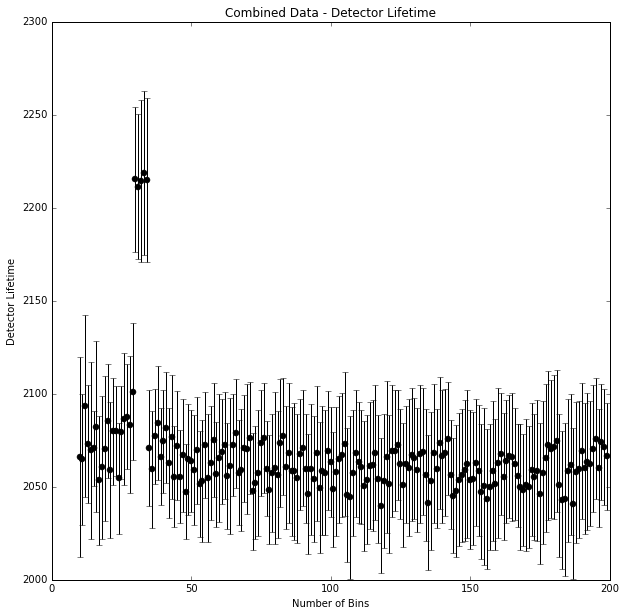

In [4]:
detectorLifeTime_Plot(combine_data,10,200,'Combined Data - Detector Lifetime')

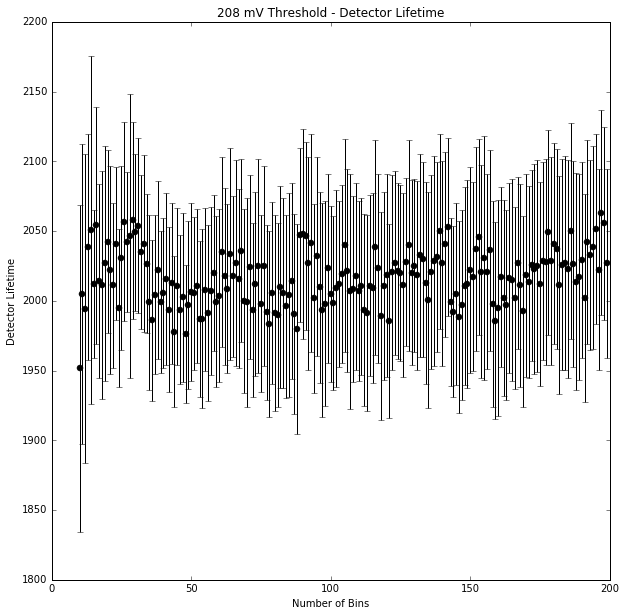

In [5]:
detectorLifeTime_Plot(data_208,10,200,'208 mV Threshold - Detector Lifetime')

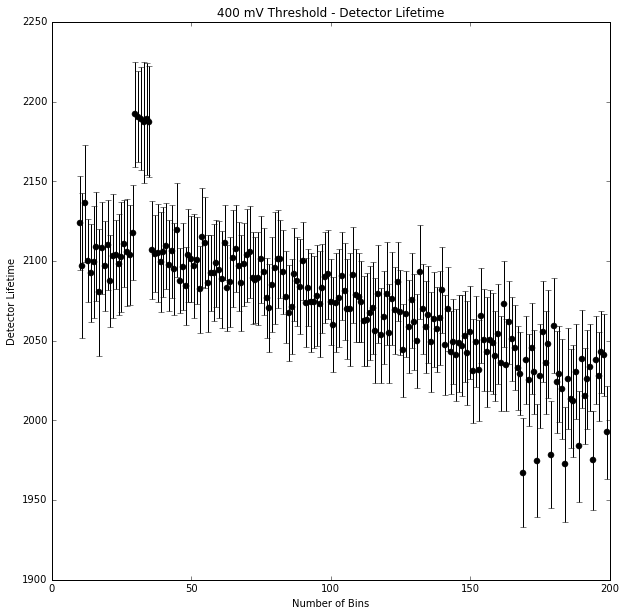

In [6]:
detectorLifeTime_Plot(data_400,10,200,'400 mV Threshold - Detector Lifetime')

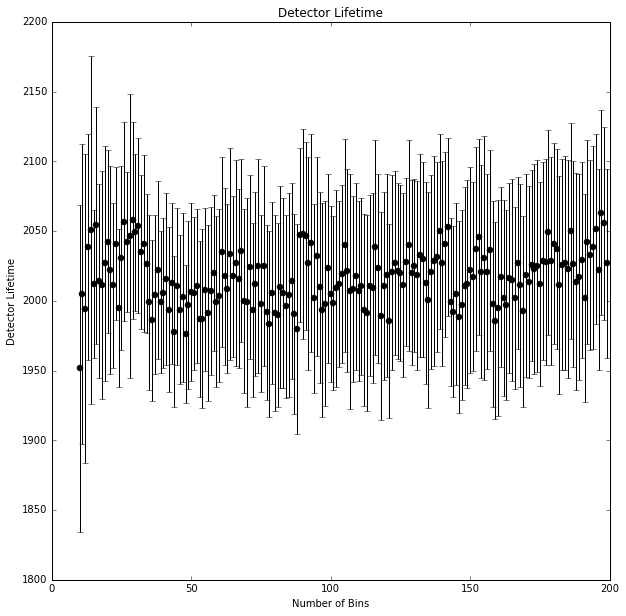

In [7]:
detectorLifeTime_Plot(data_208,10,200)

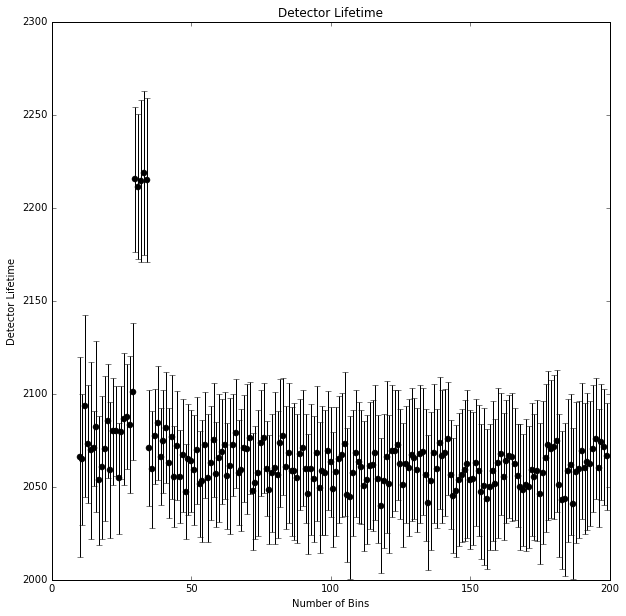

In [8]:
detectorLifeTime_Plot(combine_data,10,200)

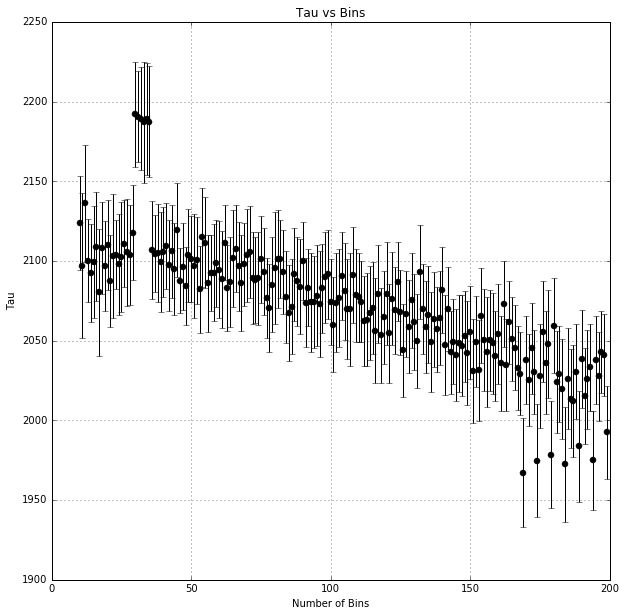

In [9]:
bestValue_Plot(data_400,10,200)

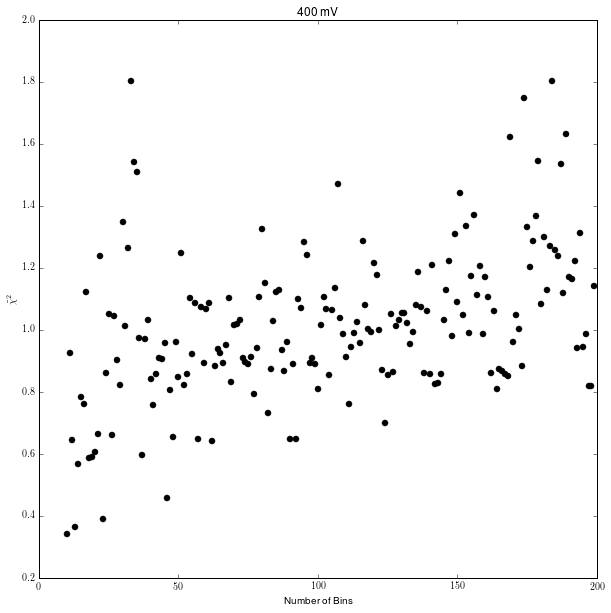

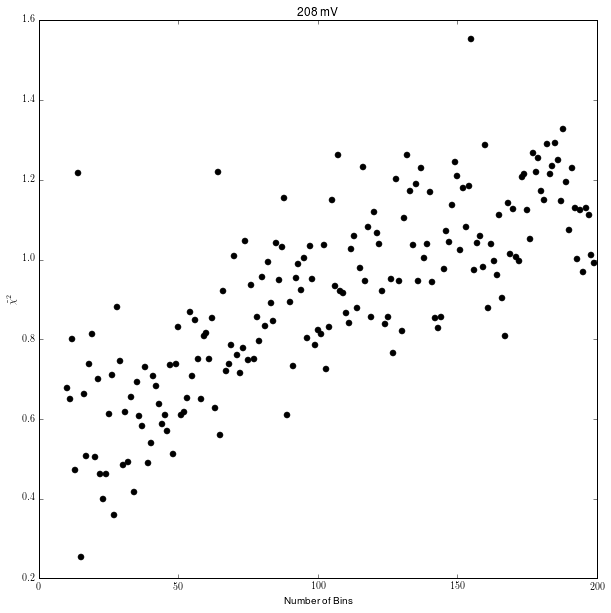

In [10]:
chiSq_Plot(data_400,10,200,'400 mV')
chiSq_Plot(data_208,10,200,'208 mV')
#chiSq_Plot(combine_data,10,200)

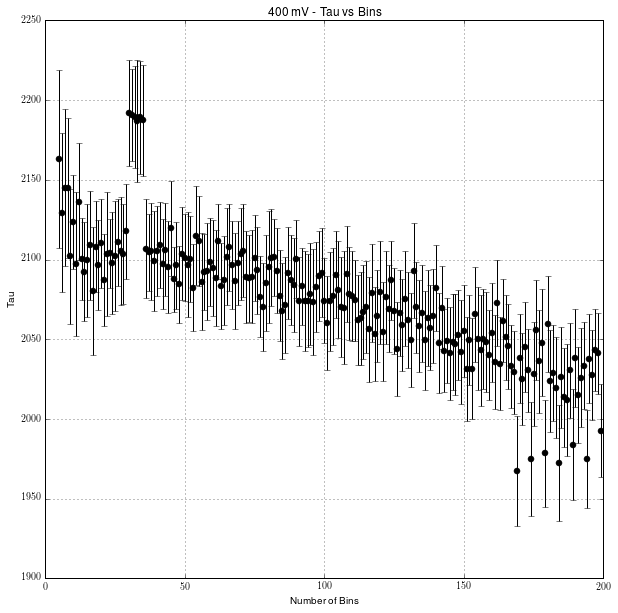

In [11]:
bestValue_Plot(data_400,5,200,'400 mV - Tau vs Bins')

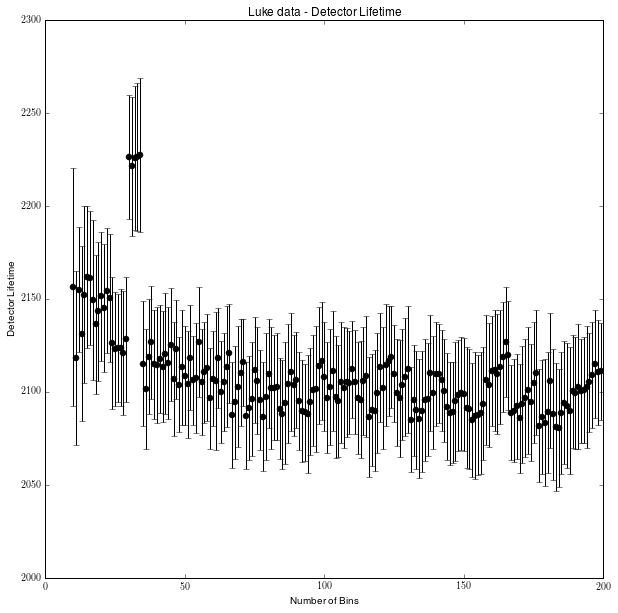

In [12]:
detectorLifeTime_Plot(data_Luke,10,200,'Luke data - Detector Lifetime')

In [13]:
data_Luke=loadtxt('Data/Luke_Ian/Luke_Perry2015_12_01-13-39.txt'\
                 ,unpack=True)[1]
data_Luke2=loadtxt('Data/Luke_Ian/Perry_LukeIntervals2015_11_24-15-11.txt'\
                 ,unpack=True)[1]

data_Luke_Ian=loadtxt('Data/Luke_Ian/Luke_Perry_IanIntervals2015_12_03-13-38.txt'\
                 ,unpack=True)[1]
data_Luke_Perry=loadtxt('Data/Luke_Ian/Perry_LukeIntervals2015_11_24-15-11.txt'\
                 ,unpack=True)[1]


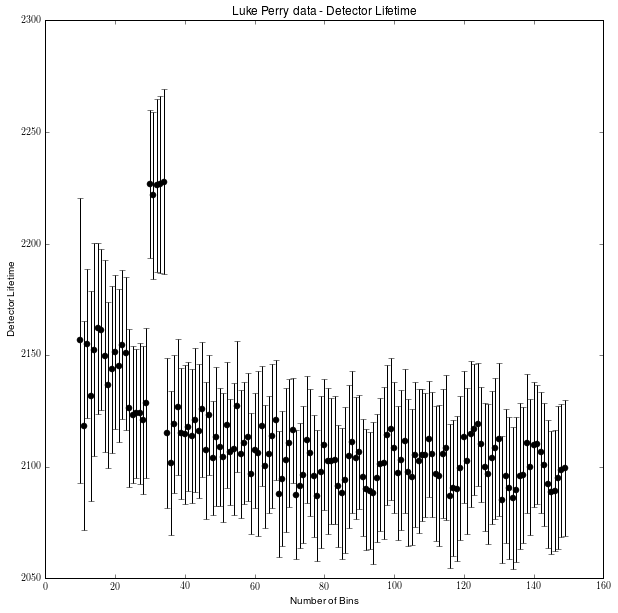

In [14]:
detectorLifeTime_Plot(data_Luke,10,150,'Luke Perry data - Detector Lifetime')

[[Model]]
    Model(expDecay)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 98
    # variables        = 3
    chi-square         = 101.062
    reduced chi-square = 1.064
[[Variables]]
    tau:          2108.51613 +/- 29.28179 (1.39%) (init= 2000)
    amp:          1231.66173 +/- 21.44310 (1.74%) (init= 1001)
    background:   16.2839356 +/- 0.653038 (4.01%) (init= 20)
[[Correlations]] (unreported correlations are <  0.100)
    C(tau, amp)                  = -0.793 
    C(tau, background)           = -0.455 
    C(amp, background)           =  0.232 



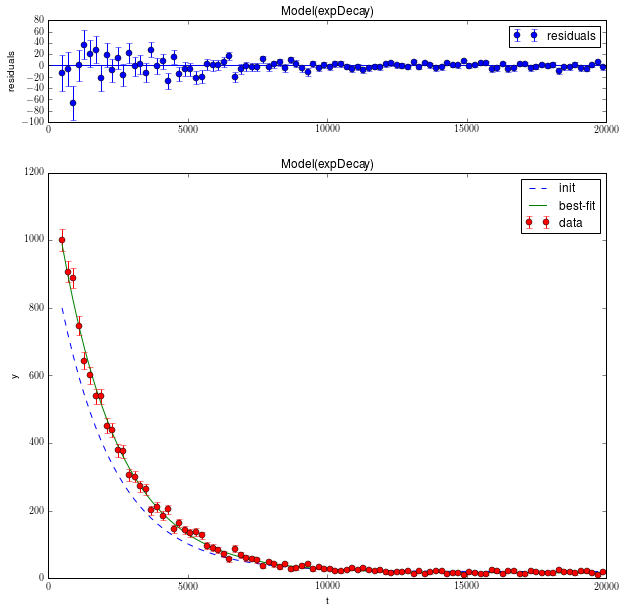

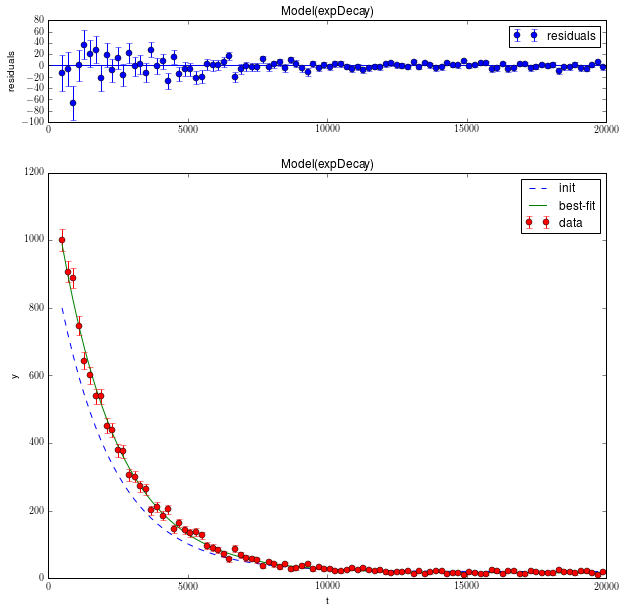

In [15]:
out=doFit(data_Luke,100)[1]
print(out.fit_report())
out.plot(fig_kws={'figsize':(10,10)})

In [16]:
tau_obs = ((out.best_values['tau'],out.params['tau'].stderr))
dectLifetime = detectorLifeTime(tau_obs[0])
print(tau_obs[1])

print(dectLifetime.std_dev/2)
print(out.fit_report())

29.2817940729
0.0010219782081828522
[[Model]]
    Model(expDecay)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 98
    # variables        = 3
    chi-square         = 101.062
    reduced chi-square = 1.064
[[Variables]]
    tau:          2108.51613 +/- 29.28179 (1.39%) (init= 2000)
    amp:          1231.66173 +/- 21.44310 (1.74%) (init= 1001)
    background:   16.2839356 +/- 0.653038 (4.01%) (init= 20)
[[Correlations]] (unreported correlations are <  0.100)
    C(tau, amp)                  = -0.793 
    C(tau, background)           = -0.455 
    C(amp, background)           =  0.232 

